# Import Data

In [184]:
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords, wordnet
import pandas as pd

text2 = pd.read_csv('Frey transcripts.csv')
transcript_seed_words = pd.read_csv('transcript manual seedword one word.csv')
# print('The number of tweets (excludes replies) before data pre-processing:',len(text2))

The number of tweets (excludes replies) before data pre-processing: 6501


In [185]:
transcript_seed_words = transcript_seed_words.dropna()
text2 = text2.dropna()
text2 = text2.drop(columns="url")
text2.rename(columns = {'tweets':'transcripts', 'Company':'transcript_name'}, inplace = True)

In [90]:
from lda import guidedlda

# Data Cleaning
1. tokenization
2. remove @users, hashtag symbols, Urls, and special symbols(i.e., '&amp'), non-alphabetic characters, and words that have less than 3 characters
3. remove stopwords
4. lowercase transformation
5. stemming

In [186]:
import gensim
import gensim.corpora as corpora
import re
porter = PorterStemmer()
stop_words = stopwords.words('english')
b = []
for i,u in text2.iterrows():
    a = []
    word =''
    for words in str(u['transcripts']).split(): #tokenization
        if '@' not in words: #remove @users
            words = words.replace('#','') #remove hashtag symbol
            if '#' not in words:
                if 'http' not in words: #remove URLs
                    if'&amp' not in words: #remove symbol
                        words = re.sub(r'[^a-zA-Z]', ' ', words)#remove non-alphabetic characters
                        if len(words)>2:
                            word += (words+' ')
    doc = ''
    for token in word.split():
        if len(token) >2: # remove words that have less than 3 characters
            token = token.lower()# lowercase form
            if token not in stop_words:# remove stopwords
                token = porter.stem(token) #stemming
                doc += (token+' ')
    b.append(doc)
text2['processed']=[i for i in b]

# exclude words that are not in English
non_english_list = ['temiz','rkiy','erik','nda','konu','dan','da','ba','al','viand','para','na','dann','uft','laboratorio','dieser','kalbimi',
                   'restoranda','evento','komo','ind','tica','futuro','sonra','yla','cre','ili','daki',
                   'zaman']
index_axis = []
for index,i in text2.iterrows():
    if len(i['processed']) == 0:
        index_axis.append(index)
    else:
        for word in i['processed'].split():
            if word in non_english_list:
                index_axis.append(index)
                break
text2.drop(text2.index[index_axis],inplace=True)
print("number of tweets after cleaning:",len(text2))

number of tweets after cleaning: 14


In [187]:
text2.groupby('transcript_name')['transcripts'].count().sort_values(ascending=False)

transcript_name
transcript 1     1
transcript 10    1
transcript 11    1
transcript 12    1
transcript 13    1
transcript 14    1
transcript 2     1
transcript 3     1
transcript 4     1
transcript 5     1
transcript 6     1
transcript 7     1
transcript 8     1
transcript 9     1
Name: transcripts, dtype: int64

# Randomly Select 20% Dataset As Our Training Set

In [188]:
text_random_20percent = text2.sample(frac=0.2, random_state=2022)

In [8]:
text_random_20percent.groupby('transcript_name')['transcripts'].count().sort_values(ascending=False)

transcript_name
transcript 10    1
transcript 4     1
transcript 6     1
Name: transcripts, dtype: int64

# Generate Bigrams

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary<0 unique tokens: []>
INFO:gensim.corpora.dictionary:built Dictionary<732 unique tokens: ['adult', 'age', 'ago', 'alaska', 'alison']...> from 14 documents (total 2250 corpus positions)
INFO:gensim.utils:Dictionary lifecycle event {'msg': "built Dictionary<732 unique tokens: ['adult', 'age', 'ago', 'alaska', 'alison']...> from 14 documents (total 2250 corpus positions)", 'datetime': '2022-08-12T13:20:10.884143', 'gensim': '4.2.0', 'python': '3.9.7 (default, Sep 16 2021, 08:50:36) \n[Clang 10.0.0 ]', 'platform': 'macOS-10.16-x86_64-i386-64bit', 'event': 'created'}
INFO:gensim.models.ldamodel:using symmetric alpha at 0.1
INFO:gensim.models.ldamodel:using symmetric eta at 0.1
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 14 documents, updating model once every 14 documents, evaluating perple

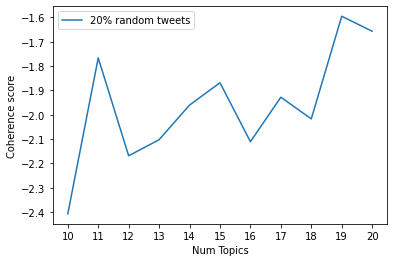

In [189]:
from gensim.models import CoherenceModel
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence),deacc=True)) #tokenization，return a list
data_words = list(sent_to_words(text2['processed'])) #tokenization
# bigram = gensim.models.Phrases(data_words,min_count=1,threshold=1)
# '''mincount：int, the times that two unigram co-occur must be equal or higher than this number，
# threshold：Phrases function will return a 'phrase score', it will decide whether two unigrams can be regarded as a bigram'''
# bigram_mod = gensim.models.phrases.Phraser(bigram) # Bigram
# def make_bigrams(texts): #Bigram
#     return [bigram[doc] for doc in texts]
# data_words_bigrams = make_bigrams(data_words)
id2word = corpora.Dictionary(data_words)#_bigrams)
texts = data_words#_bigrams
corpus = [id2word.doc2bow(text) for text in texts]


def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start,limit,step):
        model=gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,random_state=2022)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
limit=21; start=10; step=1
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=start, limit=limit, step=step)
#Show graph
import matplotlib.pyplot as plt
x = range(start, limit, step)
plt.plot(x, coherence_values,label='20% random tweets')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(loc='best')
plt.xticks(range(start,limit,step))
plt.show()

In [165]:
# lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=id2word,num_topics=11,random_state=2022,alpha='auto',per_word_topics=True)
# #pprint(lda_model.print_topics(num_words=400))
# amount =0
# for idx, topic in lda_model.show_topics(formatted=False,num_topics=11,num_words= 500):
#     print('\n',end='')
#     print('Topic:',idx)
#     num = 0
#     for w in topic:
#         # if '_' in w[0] and num: #< 50
#             print(round(w[1],4),'*',w[0],', ',end='',sep='')
#             print('(',w[0],') ',end='',sep='')
#             num += 1 
#             amount+=1

In [166]:
# print(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [96]:
import sklearn.feature_extraction

# GuidedLDA Model
latent topics are identified from the bigrams shown above.

In [213]:
#survivor
seed_words = [['god','hope','pray','believ','trust','church','convict','optim','religion','ideaolog','confid','group','relationship',
      'mass','synagogu','anticip','futur','strong','lord','readi','wait','focu','posit','plan','support',
      'desir','accept','loyal','truth','assent','assur','constant','credenc','credul','depend','fealti',
        'relianc','sure','sureti','troth', 
               'electr','disast', 'float', 'hope', 'chang', 'brighter','gratitud','faith', 'opportun', 'love', 'pray', 'hope', 'likelihood'],#0 Faith
      ['tumor','radiolog','chemotherapi','benign','invas','mastectomi','surgeri','malign','metastasi','melanoma',
       'carcigen','cancer','precancer','survivor','diseas','sick','ill','spread','lump','cell','grow','neck','bodi',
       'organ','lung','heal','emerg','oncologist','prescript','m.d.','test','pass','prognosi','migran','seizur','c.t.',
       'scan','imag','heartbeat','diagnosi','biopsi','remov','carcinoma','big c', 'live', 
       'pass', 'radiat', 'kidney', 'chemo'],#1 Cancer
      ['earth','sun','sky','star','tree','flower','land','sea','ocean','lake','river','rain','storm','thunder',
       'lighten','snow','sunset','sunris','outsid','leaf','trek','wilder','anim','stream','rock','bolt','flood',
       'weather','water','hurrican','morn','night','world','life','environ','landscap','view','cosmo','countri','forest',
       'macrocosm','outdoor','sceneri','seascap',
       'set','univers','natur', 'cano', 'alaska', 'hike', 
       'forest', 'fire', 'soil', 'canyon', 'butterfli', 'camp', 
       'gear', 'flower', 'mountain', 'hike', 'paddl', 'sunris', 'boat', 'backcountri'],#2 Nature
      ['reflect','care','self car','health','consider','conscienti','regard','thought','thougt','well',
       'well-b','feel','mental health','introspect','meditat','center','concentr','breath','relax','sit','focu',
       'yoga','bodi','hardship','redifin','experi','sign','know','heal',
       'posit','mind','deep','bodi','sens','tension','paus','notic','heartbeat',
       'heart','check','self-esteem','confid','alert','care',
       'concern','direct','forethougt',
       'head','heed','interest','pain','regard',
      'sens','breath','bodi','notic','posit','self-encourag','feel','reset','whole','chang',
       'found','float','need','connect','let go','welcom','inspir','connect','creat','feast',
       'feel','coma']]#3 Mindfullness

In [217]:
from sklearn.feature_extraction.text import CountVectorizer
from lda import guidedlda as guidedlda
import numpy as np
model = guidedlda.GuidedLDA(n_topics=4,n_iter=1000,random_state=2022,refresh=10,alpha=0.01,eta=0.01) #alpha=0.01,eta=0.01

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(text2['processed'])

vocab = vectorizer.get_feature_names()
procab = vectorizer.get_feature_names()
word2id = dict((v,idx) for idx,v in enumerate(vocab))
seed_topics = {}
for t_id, st in enumerate(seed_words):
    for word in st:
        try:
            seed_topics[word2id[word]] = t_id
        except:
            print(word," skipped")

model.fit(X.toarray(),seed_topics=seed_topics,seed_confidence=0.7) #set seed confidence to 0.7
topic_word = model.topic_word_
n_top_words = 20
vocab = tuple(vocab)

for i, topic_dist in enumerate(topic_word): #Print out results
    print('\n')
    print('Topic:',i)
    words_probability = np.array(-topic_dist)
    for index in range(n_top_words):
        print(round(abs(np.sort(words_probability))[:(n_top_words)][index],4),'*',
              np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1][index],sep='',end='  ') 

INFO:lda:n_documents: 14
INFO:lda:vocab_size: 732
INFO:lda:n_words: 2250
INFO:lda:n_topics: 4
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -20748
INFO:lda:<10> log likelihood: -17083
INFO:lda:<20> log likelihood: -16936
INFO:lda:<30> log likelihood: -16906
INFO:lda:<40> log likelihood: -16871
INFO:lda:<50> log likelihood: -16851
INFO:lda:<60> log likelihood: -16876


believ  skipped
trust  skipped
church  skipped
convict  skipped
optim  skipped
religion  skipped
ideaolog  skipped
mass  skipped
synagogu  skipped
anticip  skipped
lord  skipped
accept  skipped
loyal  skipped
truth  skipped
assent  skipped
assur  skipped
constant  skipped
credenc  skipped
credul  skipped
depend  skipped
fealti  skipped
relianc  skipped
sure  skipped
sureti  skipped
troth  skipped
electr  skipped
disast  skipped
radiolog  skipped
benign  skipped
invas  skipped
malign  skipped
metastasi  skipped
melanoma  skipped
carcigen  skipped
precancer  skipped
survivor  skipped
diseas  skipped
sick  skipped
ill  skipped
spread  skipped
lump  skipped
cell  skipped
organ  skipped
heal  skipped
m.d.  skipped
migran  skipped
c.t.  skipped
carcinoma  skipped
big c  skipped
sky  skipped
tree  skipped
sea  skipped
ocean  skipped
lake  skipped
storm  skipped
thunder  skipped
lighten  skipped
snow  skipped
sunset  skipped
leaf  skipped
trek  skipped
wilder  skipped
anim  skipped
stream  ski

INFO:lda:<70> log likelihood: -16808
INFO:lda:<80> log likelihood: -16713
INFO:lda:<90> log likelihood: -16651
INFO:lda:<100> log likelihood: -16619
INFO:lda:<110> log likelihood: -16618
INFO:lda:<120> log likelihood: -16502
INFO:lda:<130> log likelihood: -16506
INFO:lda:<140> log likelihood: -16444
INFO:lda:<150> log likelihood: -16428
INFO:lda:<160> log likelihood: -16382
INFO:lda:<170> log likelihood: -16361
INFO:lda:<180> log likelihood: -16409
INFO:lda:<190> log likelihood: -16398
INFO:lda:<200> log likelihood: -16460
INFO:lda:<210> log likelihood: -16441
INFO:lda:<220> log likelihood: -16372
INFO:lda:<230> log likelihood: -16365
INFO:lda:<240> log likelihood: -16396
INFO:lda:<250> log likelihood: -16339
INFO:lda:<260> log likelihood: -16430
INFO:lda:<270> log likelihood: -16377
INFO:lda:<280> log likelihood: -16389
INFO:lda:<290> log likelihood: -16344
INFO:lda:<300> log likelihood: -16327
INFO:lda:<310> log likelihood: -16330
INFO:lda:<320> log likelihood: -16276
INFO:lda:<330> 



Topic: 0
0.0612*right  0.0416*yeah  0.0263*lar  0.0241*go  0.0219*phil  0.0197*guy  0.0197*talk  0.0175*hold  0.0175*guid  0.0175*okay  0.0131*well  0.0131*abl  0.0131*say  0.0131*let  0.011*god  0.011*look  0.011*stranger  0.011*star  0.011*littl  0.011*tri  

Topic: 1
0.037*year  0.0278*lar  0.0255*right  0.0255*cancer  0.0255*deni  0.0232*four  0.0208*diagnos  0.0208*yeah  0.0185*mastectomi  0.0162*still  0.0162*month  0.0139*differ  0.0139*alway  0.0139*three  0.0139*hello  0.0139*michel  0.0116*anyth  0.0116*old  0.0116*alison  0.0116*lost  

Topic: 2
0.0501*elizabeth  0.0251*breath  0.0188*kid  0.0146*part  0.0146*move  0.0125*thing  0.0125*justin  0.0125*notic  0.0125*call  0.0105*adopt  0.0105*week  0.0105*huge  0.0105*take  0.0105*kind  0.0105*want  0.0105*bodi  0.0105*agenc  0.0105*nurs  0.0084*probabl  0.0084*everyon  

Topic: 3
0.0418*like  0.0308*lindsey  0.0308*know  0.0275*one  0.0242*come  0.0231*realli  0.0209*see  0.0198*would  0.0176*think  0.0176*get  0.0165*time 

# Company-Topic Heatmap
Based on proportion of each topic for each company

In [223]:
doc_topic = model.transform(X)
topic_number1 = []

for i in range(len(doc_topic)):
    topic_number1.append(doc_topic[i].argmax())
text2['topic number'] = [i for i in topic_number1]
text2

,Unnamed: 0,transcripts,date,transcript_name,processed,topic number
0,0.0,Scene 4\n\nLars: [00:15:35] 35. [00:15:30]\n\n...,1/5/21 15:59,transcript 1,scene lar lar know bag everyth yeah yeah one t...,1
1,1.0,scene_2.wav\nElizabeth: [00:00:01] This is my ...,12/30/20 23:14,transcript 2,scene wav elizabeth case run realli fast away ...,2
2,2.0,scene_3.wav\nLindsey: [00:00:03] Before I was ...,12/23/20 19:00,transcript 3,scene wav lindsey diagnos still colleg found t...,3
3,4.0,Scene 4\n\nLars: [00:15:35] 35. [00:15:30]\n\n...,12/16/20 21:26,transcript 4,scene lar lar know bag everyth yeah yeah one t...,1
4,5.0,Scene 5\n\nElizabeth: [00:21:32] So [00:21:30]...,12/15/20 20:16,transcript 5,scene elizabeth saw hematologist oncologist fi...,0
5,6.0,Scene 6\n\nMaynard: [00:26:28] I noticed water...,12/10/20 0:24,transcript 6,scene maynard notic water reflect light onto s...,3
6,8.0,"Scene 7\n\nLars: [00:28:45] Hey, [00:28:30] gu...",12/8/20 0:13,transcript 7,scene lar hey guy good job welcom camp right r...,0
7,9.0,Scene 8\n\nLindsey: [00:31:10] I [00:31:00] ju...,12/5/20 14:13,transcript 8,scene lindsey see make feel big yet small roy ...,3
8,10.0,Scene 9\n\nLindsey: [00:32:51] Probably. Just ...,12/3/20 23:32,transcript 9,scene lindsey probabl tri build fire get done ...,3
9,11.0,"Scene 10\n\nLindsey: [00:36:15] Oh, yeah.\n\nL...",11/26/20 22:05,transcript 10,scene lindsey yeah lindsey went trip septemb s...,3
